# Salt_Obs_Pan05

In [2]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46729,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38463,Total threads: 1
Dashboard: /proxy/35299/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44823,


### Importing the data

In [4]:
# Model data
lat_slice = slice(None,-39)
paths_model = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))

In [5]:
# Importing obs
shelf = xr.open_dataset('/g/data/g40/akm157/data/schmidtko/AASW_Temp_Salt.nc', chunks='auto')['AS'].sel(lat=lat_slice)
deep =  xr.open_dataset('/g/data/ik11/observations/woa23/woa23_decav_s00_04.nc', decode_times=False)['s_an'].sel(lat=lat_slice)

In [6]:
# Loading model data
def preprocess_model(ds):
    ds = ds[['so']].sel(yh=slice(None,-39))
    return ds
    
model = xr.open_mfdataset(paths_model, preprocess = preprocess_model, chunks = {'time': 20, 'xh': 100, 'yh': 100})

## Converting all into AS

In [7]:
# Converting model to AS
# Calculating pressure
p_model = gsw.p_from_z(-model['z_l'], model['yh'])

# Calculating absolute salinity
SA_model = gsw.SA_from_SP(model['so'], p_model, model['xh'], model['yh'])

In [8]:
# Taking the average of the ten years after spin up
salt_model_ave = SA_model.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [9]:
salt_model_ave

<xarray.DataArray 'so' (z_l: 75, yh: 1641, xh: 7200)> Size: 7GB
dask.array<mean_agg-aggregate, shape=(75, 1641, 7200), dtype=float64, chunksize=(38, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 13kB -81.1 -81.08 -81.06 ... -39.09 -39.05 -39.01
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

## Getting bottom masks

In [10]:
# Extracting temperature at bottom
bottom_mask_model = salt_model_ave.where(~np.isfinite(salt_model_ave.shift({'z_l': -1})))
bottom_mask_model = ~np.isnan(bottom_mask_model)

botsalt_model_map = salt_model_ave.where(bottom_mask_model).sum(dim='z_l')

In [11]:
botsalt_model_map = botsalt_model_map.astype('float32')
botsalt_model_map

<xarray.DataArray 'so' (yh: 1641, xh: 7200)> Size: 47MB
dask.array<astype, shape=(1641, 7200), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 13kB -81.1 -81.08 -81.06 ... -39.09 -39.05 -39.01

In [12]:
botsalt_model_map = botsalt_model_map.load()

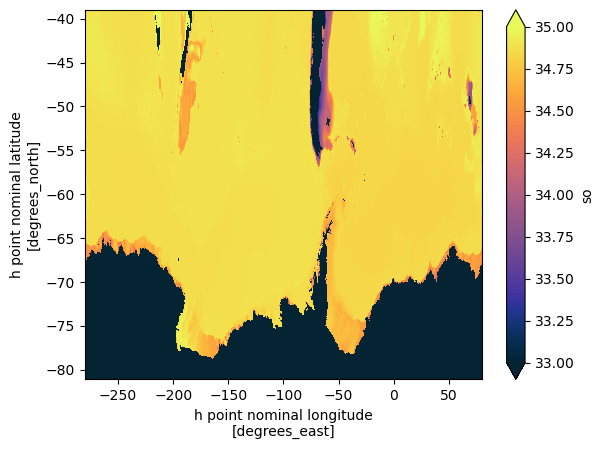

In [13]:
botsalt_model_map.plot(vmin=33,vmax=35,cmap=cm.cm.thermal)

### Fix up the land masks

In [14]:
botsalt_model_map_new = botsalt_model_map.where(botsalt_model_map != 0, np.nan)
botsalt_model_map_new

<xarray.DataArray 'so' (yh: 1641, xh: 7200)> Size: 47MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [34.91057 , 34.910328, 34.91011 , ..., 34.911015, 34.910927,
        34.910778],
       [34.91042 , 34.910168, 34.90993 , ..., 34.910942, 34.910805,
        34.91063 ],
       [34.910194, 34.909912, 34.909626, ..., 34.910843, 34.910656,
        34.91043 ]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 13kB -81.1 -81.08 -81.06 ... -39.09 -39.05 -39.01

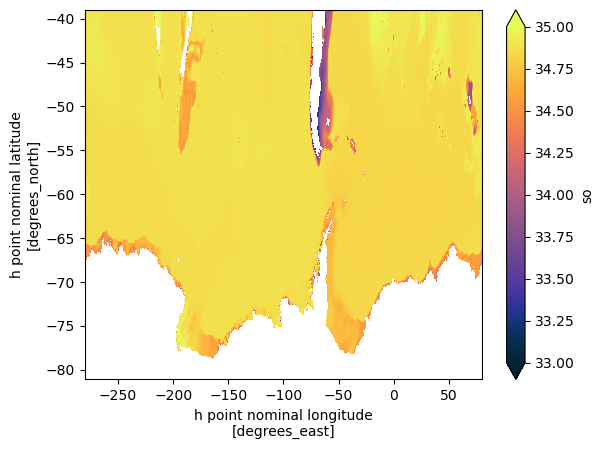

In [15]:
botsalt_model_map_new.plot(vmin=33,vmax=35,cmap=cm.cm.thermal)

In [16]:
botsalt_model_map_new.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_sob_last10yrave.nc')

### Taking the anomalies

In [17]:
botsalt_model_map_new = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/pan005_control_sob_last10yrave.nc',decode_times=False)
botsalt_deep_map_new = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/deep_WOA23_sob_last10yrave.nc',decode_times=False)
botsalt_shelf_map_new = xr.open_dataarray('/g/data/x77/kc5856/thesis_model_validation/shelf_schmidtko_sob_last10yrave.nc',decode_times=False)

Shelf obs and model are both on 1/10th degree grids. (but not identical).  
WOA is on 1/4 degree.  
So we need to do some regridding.

In [18]:
import xesmf as xe

In [19]:
botsalt_model_map_new = botsalt_model_map_new.rename({'xh': 'lon', 'yh': 'lat'}) # comment out if already done this session

In [20]:
# Build regridder from model grid -> obs grid
# xESMF expects coords named 'lon' and 'lat' (or specify lon/lat dims explicitly).
regridder = xe.Regridder(botsalt_model_map_new, botsalt_deep_map_new, method='conservative')  # or 'bilinear'

# Regrid the high-res model onto the obs grid
model_on_obs = regridder(botsalt_model_map_new)

In [21]:
# compute anomaly
anomaly_deep = model_on_obs - botsalt_deep_map_new   # model minus obs (change sign if you prefer obs-model)

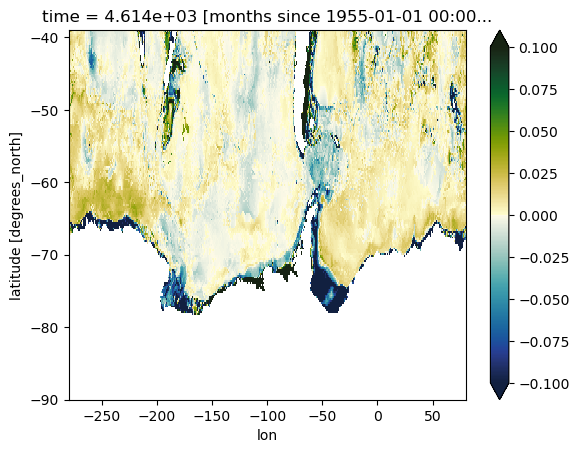

In [22]:
anomaly_deep.plot(vmin=-.1,vmax=.1,cmap=cm.cm.delta) # checking -1 to 1 range against Schmidt et al, 2025.

In [27]:
anomaly_deep.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_sob_deep_anomaly.nc')

Doing the shelf anomaly:

In [28]:
# Check if grids are the same
print(botsalt_model_map_new.lon.equals(botsalt_shelf_map_new.lon))
print(botsalt_model_map_new.lat.equals(botsalt_shelf_map_new.lat))


False
False


In [29]:
## Model and shelf obs regridding
# Create regridder: model -> obs
regridder_shelf = xe.Regridder(botsalt_model_map_new, botsalt_shelf_map_new, method='conservative', periodic=True, reuse_weights=False)

# Regrid model onto obs grid
model_on_obs_shelf = regridder_shelf(botsalt_model_map_new)

In [30]:
shelf_mask = ~np.isnan(botsalt_shelf_map_new)  # True where obs exist (shelf)
anomaly_shelf = model_on_obs_shelf - botsalt_shelf_map_new   # model minus obs
anomaly_shelf = anomaly_shelf.where(shelf_mask)   # mask outside shelf

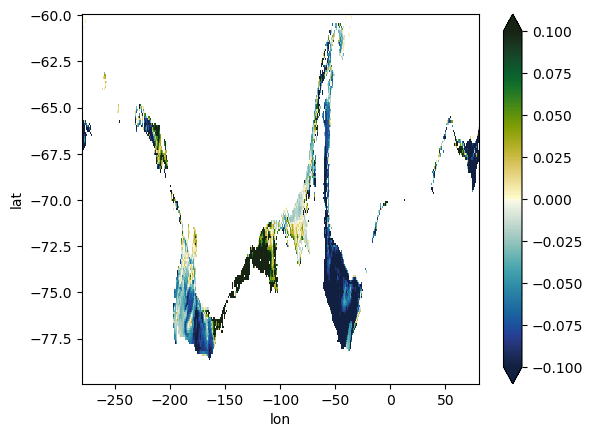

In [31]:
anomaly_shelf.plot(vmin=-.1,vmax=.1,cmap=cm.cm.delta)

In [32]:
# Save anomalies
anomaly_shelf.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_sob_shelf_anomaly.nc')

## Plotting

In [45]:
anomaly_deep = xr.open_dataset('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_sob_deep_anomaly.nc',decode_times=False).to_array()
anomaly_shelf = xr.open_dataset('/g/data/x77/kc5856/thesis_model_validation/pan005_control_obs_sob_shelf_anomaly.nc',decode_times=False).to_array()

In [46]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [47]:
# Shelf contour
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [49]:
import matplotlib.patches as mpatches

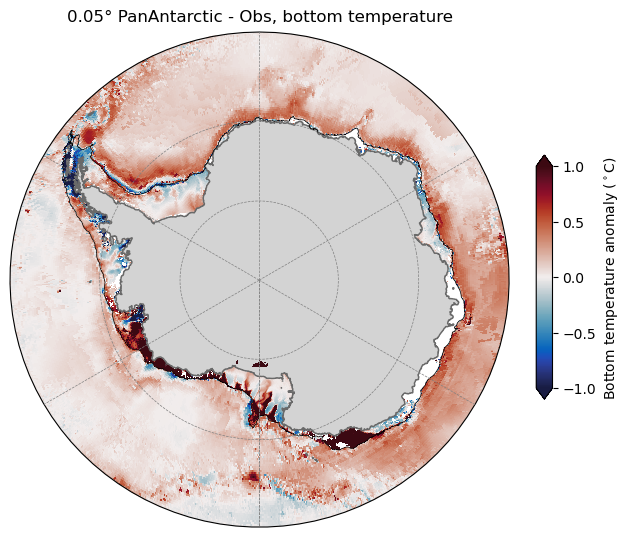

In [50]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='lightgrey',
                   zorder=3,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Add a light grey circle patch to get last bit of land
circle_patch = mpatches.Circle(
    (0, 0),  # center at South Pole in projection coordinates
    radius=1000000,  # adjust radius until circle ends around -80° latitude
    facecolor='lightgrey',
    edgecolor=None,
    zorder=2,
    transform=ccrs.SouthPolarStereo()
)
ax.add_patch(circle_patch)

#Plotting
anomaly_deep.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-.1,
    vmax=.1,
    extend="both",
    cmap=cm.cm.delta, #cm ocean colour maps for more options, matplotlib has more also.
    add_colorbar=False,
    zorder= 1
)

# White shelf mask in between
shelf_mask.where(shelf_mask == 1).plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap="gray",  # black=0, white=1
    vmin=0, vmax=1,
)


anomaly_shelf.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-.1,
    vmax=.1,
    extend="both",
    cmap=cm.cm.delta, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom abs. salinity anomaly (g/kg)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    zorder= 4
)

# Longitudes
for lon in range(-180, 181, 60):
    ax.plot([lon, lon], [-90, -59],
            transform=ccrs.PlateCarree(),
            color="gray", linestyle="--", linewidth=0.5, zorder=20)

# Latitudes
for lat in (-80, -70, -55):
    lons = np.linspace(-280, 80, 400)
    ax.plot(lons, [lat]*len(lons),
            transform=ccrs.PlateCarree(),
            color="gray", linestyle="--", linewidth=0.5, zorder=20)


# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=1, transform = ccrs.PlateCarree(), zorder=15)
# Shelf contour
ax.contour(shelf_mask['xh'], shelf_mask['yh'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree(), zorder=15)


plt.title("0.05° PanAntarctic - Obs, bottom salinity");